Финальный проект по курсу от компании "Мегафон"
---

**Задача: сформировать персональные предложения абонентам компании "Мегафон"**

```
Задача состоит из 2-х подзадач:
1. Предсказание вероятности подключения услуги
2. Формирование индивидуальных предложений и максимизация выручки

Представлен датасет:
- откликов абонентов на те или иные продукты
- профиль потребеления абонентов
```

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

**Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц**. 

Итого, в качестве входных данных будут представлены:
- **data_train.csv**: id, vas_id, buy_time, target
- **features.csv.zip**: id, <feature_list> 

И тестовый набор:
- data_test.csv: id, vas_id, buy_time
  - **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
  - **buy_time** - время покупки, представлено в формате `timestamp`, для работы с этим столбцом понадобится функция `datetime.fromtimestamp` из модуля `datetime`.
  - **id** - идентификатор абонента
  - **vas_id** - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы с ним можно воспользоваться `pandas.read_csv`, либо можно воспользоваться библиотекой `Dask`.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция `sklearn.metrics.f1_score(…, average='macro')`. 
[sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score)

**Формат представления результата**

1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука. 
3. Презентация в формате .pdf, в которой необходимо отразить:
    - Информация о модели, ее параметрах, особенностях и основных результатах.
    - Обоснование выбора модели и ее сравнение с альтернативами.
    - Принцип составления индивидуальных предложений для выбранных абонентов.
    Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку "курсовой проект".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib2 import Path
import sys
from datetime import date
import itertools

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline

In [2]:
path = Path('../../data/megafon/')

# Загрузка данных

In [3]:
train = pd.read_csv(path.joinpath('data_train.csv')).drop(['Unnamed: 0'], axis=1)
train

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0
831651,1825525,2.0,1546203600,0.0


In [4]:
test = pd.read_csv(path.joinpath('data_test.csv')).drop(['Unnamed: 0'], axis=1)
test

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400
...,...,...,...
71226,2502453,5.0,1548018000
71227,1693213,2.0,1548018000
71228,1891350,2.0,1548018000
71229,2437172,2.0,1548018000


<div class="alert alert-danger">
Файл features.csv загружается в оперативу 4-5 мин и занимает 9 Гб.
</div>

In [5]:
features = pd.read_csv(path.joinpath('features.csv'), sep='\t').drop(['Unnamed: 0'], axis=1)
features

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512523,3521417,1548018000,-96.799971,-29.579112,-94.900786,-40.506798,-100.318246,-61.61179,-16.08618,-65.076097,...,1133.626154,1497.229208,-25.996269,-36.630448,-126.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512524,3521563,1547413200,30.530029,-150.929112,16.589214,-34.046798,11.171754,-55.15179,-16.08618,-65.076097,...,-680.373846,-316.770792,-25.996269,-35.630448,-296.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512525,3521574,1546808400,-96.799971,-396.439112,-110.740786,-447.776798,-116.158246,-468.88179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512526,3521640,1547413200,38.030029,-152.519112,24.089214,-175.956798,18.671754,-197.06179,-16.08618,-65.076097,...,2242.626154,2528.229208,-25.996269,90.369552,-26.747724,-18.832889,-0.694428,-12.175933,0.54386,0.0


In [6]:
# размер features в памяти
sys.getsizeof(features)

9205557264

## Проверка, что признак равен нулю

In [7]:
features[['75', '81', '85', '139', '203']].describe()

,75,81,85,139,203
count,4512528.0,4512528.0,4512528.0,4512528.0,4512528.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [8]:
features.drop(['75', '81', '85', '139', '203'], axis=1, inplace=True)

**Избавились от 5-ти нулевых признаков**.

In [9]:
features.head(2)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0


## Преобразуем `buy_time` к дате.

In [10]:
train['buy_time'] = train['buy_time'].apply(lambda data: date.fromtimestamp(data))

In [11]:
train.head(3)

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-17,0.0
1,1454121,4.0,2018-07-16,0.0
2,2458816,1.0,2018-08-13,0.0


In [12]:
test['buy_time'] = test['buy_time'].apply(lambda data: date.fromtimestamp(data))
test.head(3)

,id,vas_id,buy_time
0,3130519,2.0,2019-01-21
1,2000860,4.0,2019-01-21
2,1099444,2.0,2019-01-07


In [13]:
features['buy_time'] = features['buy_time'].apply(lambda data: date.fromtimestamp(data))
features.head(3)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-15,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-24,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


# Сохраняем в `pkl`

In [34]:
train.to_pickle(path.joinpath('train.pkl'))

In [35]:
test.to_pickle(path.joinpath('test.pkl'))

In [36]:
features.to_pickle(path.joinpath('features.pkl'))

<div class="alert alert-danger">
<h1>Загружаем из pkl</h1>
</div>

In [3]:
train = pd.read_pickle(path.joinpath('train.pkl'))

In [4]:
test = pd.read_pickle(path.joinpath('test.pkl'))

In [5]:
features = pd.read_pickle(path.joinpath('features.pkl'))

# Обзор данных

## Проверка на пропуски

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  object 
 3   target    831653 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 25.4+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [16]:
features.isnull().values.any()

False

**Датасеты не содержат пропусков**

## Распределения

### Распределение целевой переменной `target`

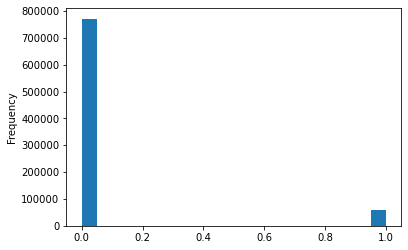

In [17]:
train['target'].plot(kind='hist',bins=20);

**Целевая переменна несбалансированна**.

### Распределение признака `vas_id`

In [18]:
train['vas_id'].nunique(), np.min(train['vas_id']), np.max(train['vas_id'])

(8, 1.0, 9.0)

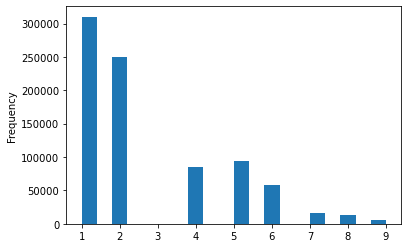

In [19]:
train['vas_id'].plot(kind='hist',bins=20);

**8 услуг с номерами от 1 до 9. Услуга под цифрой 3 отсутствует**.

In [20]:
test['vas_id'].nunique(), np.min(test['vas_id']), np.max(test['vas_id'])

(8, 1.0, 9.0)

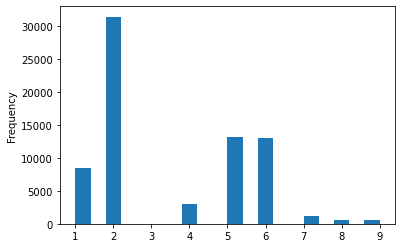

In [21]:
test['vas_id'].plot(kind='hist',bins=20);

**Распределение подключённых услуг на трейне и тесте различаются**.

### Диапазоны дат трейна и теста

In [22]:
np.min(train['buy_time']), np.max(train['buy_time'])

(datetime.date(2018, 7, 9), datetime.date(2018, 12, 31))

In [23]:
np.min(test['buy_time']), np.max(test['buy_time'])

(datetime.date(2019, 1, 7), datetime.date(2019, 1, 21))

**Трейн**: 9 июля 2018 г - 31 декабря 2018 г.

**Тест**: 7 января 2019 г - 21 января 2019 г.

### Распределение `id` абонентов

In [24]:
train['id'].nunique(), np.min(train['id']), np.max(train['id'])

(806613, 2, 4362694)

In [25]:
test['id'].nunique(), np.min(test['id']), np.max(test['id'])

(70152, 55, 4362720)

In [26]:
features['id'].nunique(), np.min(features['id']), np.max(features['id'])

(4362739, 0, 4362738)

**В датасете features содержатся данные по всем 4 млн. 362 тыс. 738 пользователям. Датасет features представлен ОДНОЙ СТРОКОЙ данных на ОДНОГО ПОЛЬЗОВАТЕЛЯ**.

**В train и test представлены подвыборки из 806 тыc. и 70 тыс. пользователей соответственно. Причём пользователи в выборка выборочные, не подряд**.

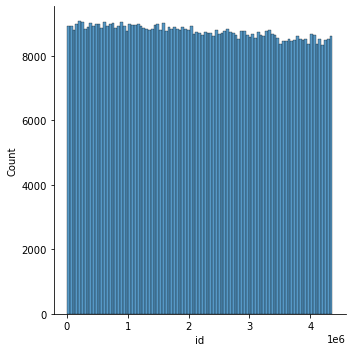

In [27]:
sns.displot(train, x='id');

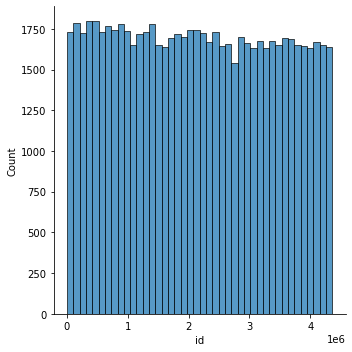

In [118]:
sns.displot(test, x='id');

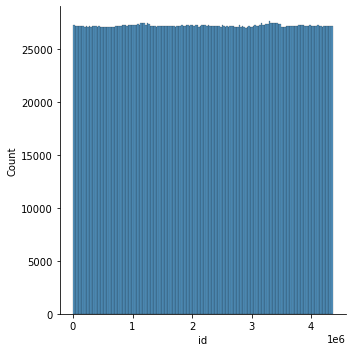

In [28]:
sns.displot(features, x='id');

**Распределение id пользователей трейна и теста скошенное. Это говорит о том, что количество новых пользователей со временем уменьшается. Но на датасете features такой закономерности не наблюдается.**

Плот корреляций строится 11 мин!

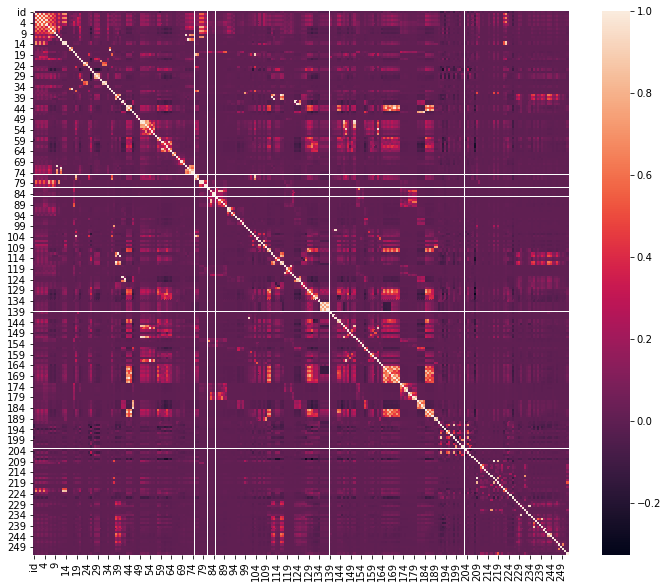

In [122]:
plt, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(features.corr(),ax=ax);

## Поиск дубликатов `id`

In [29]:
train.duplicated(subset=['id']).value_counts()

False    806613
True      25040
dtype: int64

In [30]:
test.duplicated(subset=['id']).value_counts()

False    70152
True      1079
dtype: int64

In [31]:
features.duplicated(subset=['id']).value_counts()

False    4362739
True      149789
dtype: int64

In [32]:
ids = train["id"]
train[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-19,1.0
14041,342,1.0,2018-11-05,0.0
19825,492,6.0,2018-12-17,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-19,1.0
...,...,...,...,...
751154,4339012,2.0,2018-11-19,1.0
248700,4347691,4.0,2018-11-26,0.0
248701,4347691,6.0,2018-11-19,1.0
366175,4350615,2.0,2018-12-10,1.0


In [33]:
print("ID уникален? ", train['id'].is_unique)
print("Есть ли дубли в строках?", train['id'].duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((train['id'].isnull().sum() > 0).sum()/len(train['id'])*100))

ID уникален?  False
Есть ли дубли в строках? 25040
Сколько процент признаков могут принимать null-значениями? 0%


# Baseline

## Добавляем фичи из features

In [167]:
train1 = pd.merge(train, features, on=['id'], how='left')
train1

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,2018-09-17,0.0,2018-11-12,-31.559971,327.360888,-45.500786,274.753202,-50.918246,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,2018-07-16,0.0,2018-07-09,547.270029,238.430888,533.329214,274.803202,527.911754,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,2018-08-13,0.0,2018-11-26,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,2018-09-03,0.0,2018-08-06,54.880029,12.970888,54.079214,-9.116798,48.661754,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,2018-09-03,0.0,2018-11-26,45.160029,295.240888,64.679214,344.283202,59.261754,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,3812226,2.0,2018-12-31,0.0,2018-07-30,29.750029,6.200888,24.279214,-37.936798,18.861754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
860048,2480469,2.0,2018-12-31,0.0,2018-07-23,-89.179971,-56.499112,-103.120786,-109.106798,-108.538246,...,-66.373846,-321.770792,-25.996269,62.369552,1167.252276,41.167111,-0.694428,54.824067,-0.45614,0.0
860049,158236,2.0,2018-12-31,0.0,2018-10-08,-96.799971,62.140888,-110.740786,9.533202,-116.158246,...,-683.373846,-470.770792,-25.996269,-37.630448,99.252276,178.167111,-0.694428,191.824067,-0.45614,0.0
860050,1825525,2.0,2018-12-31,0.0,2018-08-06,-96.799971,-81.919112,-110.740786,-128.596798,-116.158246,...,1018.626154,1367.229208,-24.996269,-35.630448,-237.747724,-21.832889,-0.694428,-8.175933,-0.45614,1.0


In [173]:
X_train, X_valid, y_train, y_valid = train_test_split(train1.drop(['target', 'buy_time_x', 'buy_time_y'], axis=1), 
                                                      train1['target'], 
                                                      test_size=0.3, 
                                                      random_state=42)

In [174]:
scaler = StandardScaler()

In [175]:
X_train_scale = scaler.fit_transform(X_train)
X_valid_scale = scaler.transform(X_valid)

In [182]:
# обозначим один из шагов пайплайна как log_reg
step_log_reg = ('log_reg', LogisticRegression(random_state=42, n_jobs=-1))

In [184]:
bl_estimator = Pipeline([
    step_log_reg
])

In [207]:
def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    # расчёт метрики на кросс-валидации
    cv_scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.3f (+/- %0.3f)" % (model_name,
                                         scoring,
                                         cv_scores['test_score'].mean(),
                                         cv_scores['test_score'].std() * 2))
    print('\n', cv_scores['test_score'])

In [188]:
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [208]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, scoring='f1_macro', model_name="Baseline");

Baseline: f1_macro = 0.496 (+/- 0.003)

 [0.49696704 0.49765722 0.4936183  0.49638776 0.49442238]


In [209]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_valid)[:,1]

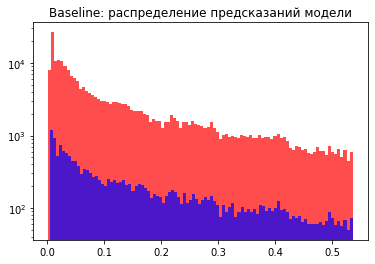

In [210]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_valid.astype(bool)], bins=100, color='r', alpha=0.7, log=True);
plt.hist(bl_y_pred[y_valid.astype(bool)], bins=100, color='b', alpha=0.7);

- красные - истинно tatget = ?
- синие - истинно target = &

На графике видно, что нет конкретнорго порога, который бы разделял бы их на 2 части идеально, поэтому мы можем построить интегральные метрики, которые будут оценивать все возможные пороги.

ROC и PR кривые строятся для всевозможных порогов. Т.е. они берут всевозможные значения которые мы предсказали на тестовой выборке, сортирует их и идут слева направо, строя кривую. 

In [212]:
fpr, tpr, roc_thresholds = roc_curve(y_valid, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_valid, bl_y_pred)

Baseline: AUC_ROC = 0.565


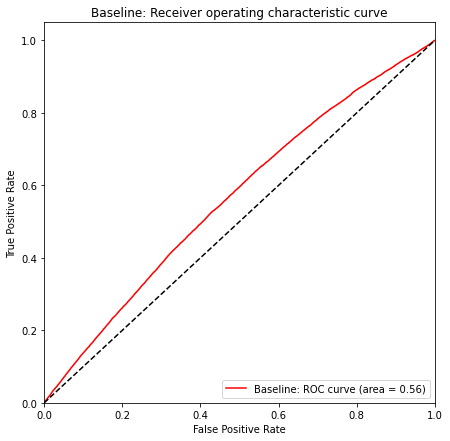

In [213]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.087


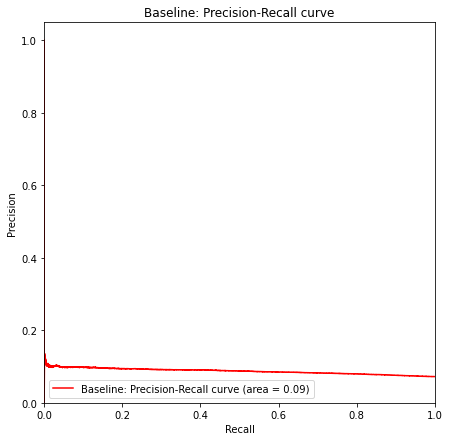

In [214]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Далее рассмотрим метрики для случая когда клссификатор предсказывает 0 или 1. Эти метрики в основном строятся на **матрице смежности - confusion matrix**.

### Матрица смежности

In [217]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[235486   3871]
 [ 18231    428]]


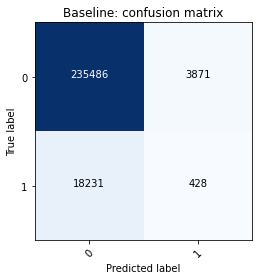

In [216]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

Построим другой бейзлайн - 3 sklearn.Pipeline из Урок_4_6_Задача_классификации.ipynb

# Baseline 2: merge_asof

In [9]:
train2 = pd.merge_asof(train.sort_values(by=['id']), 
                       features.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')
train2

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2,2.0,2018-12-24,0.0,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,15,1.0,2018-08-13,0.0,49.150029,10.390888,63.159214,11.993202,57.741754,-9.11179,...,-950.373846,-593.770792,-24.996269,-37.630448,81.252276,-4.832889,-0.694428,8.824067,-0.45614,1.0
3,16,2.0,2018-10-29,0.0,42.570029,138.740888,28.629214,86.133202,23.211754,65.02821,...,1394.626154,1272.229208,-22.996269,-36.630448,-6.747724,-23.832889,-0.694428,-12.175933,-0.45614,0.0
4,29,1.0,2018-08-06,0.0,-52.309971,-225.139112,-66.250786,-258.246798,-71.668246,-279.35179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,4362634,1.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831649,4362640,2.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831650,4362647,6.0,2018-12-31,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831651,4362684,5.0,2018-12-24,0.0,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train2.drop(['target', 'buy_time'], axis=1), 
                                                      train2['target'], 
                                                      test_size=0.3, 
                                                      random_state=42)

In [11]:
scaler = StandardScaler()

In [26]:
X_train_scale = scaler.fit_transform(X_train)
X_valid_scale = scaler.transform(X_valid)

In [27]:
# обозначим один из шагов пайплайна как log_reg
step_log_reg = ('log_reg', LogisticRegression(random_state=42, n_jobs=-1))

In [28]:
bl_estimator = Pipeline([
    step_log_reg
])

In [29]:
def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    # расчёт метрики на кросс-валидации
    cv_scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.3f (+/- %0.3f)" % (model_name,
                                         scoring,
                                         cv_scores['test_score'].mean(),
                                         cv_scores['test_score'].std() * 2))
    print('\n', cv_scores['test_score'])

In [30]:
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, scoring='f1_macro', model_name="Baseline");

Baseline: f1_macro = 0.496 (+/- 0.004)

 [0.49783029 0.49857127 0.49637865 0.49480644 0.49353816]


In [32]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_valid)[:,1]

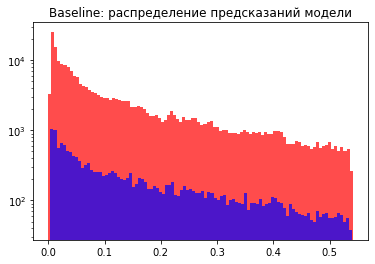

In [33]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_valid.astype(bool)], bins=100, color='r', alpha=0.7, log=True);
plt.hist(bl_y_pred[y_valid.astype(bool)], bins=100, color='b', alpha=0.7);

- красные - истинно tatget = ?
- синие - истинно target = &

На графике видно, что нет конкретнорго порога, который бы разделял бы их на 2 части идеально, поэтому мы можем построить интегральные метрики, которые будут оценивать все возможные пороги.

ROC и PR кривые строятся для всевозможных порогов. Т.е. они берут всевозможные значения которые мы предсказали на тестовой выборке, сортирует их и идут слева направо, строя кривую. 

In [34]:
fpr, tpr, roc_thresholds = roc_curve(y_valid, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_valid, bl_y_pred)

Baseline: AUC_ROC = 0.567


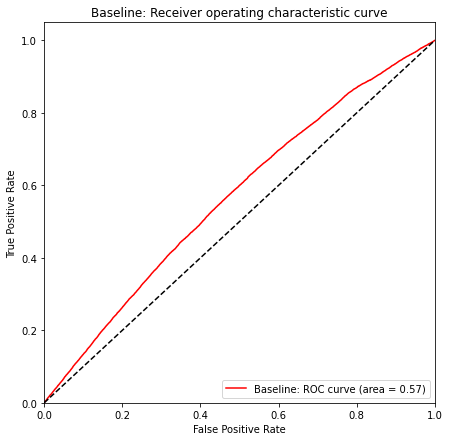

In [35]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.087


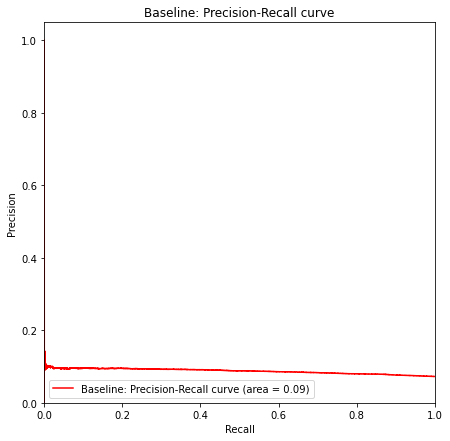

In [36]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Далее рассмотрим метрики для случая когда клссификатор предсказывает 0 или 1. Эти метрики в основном строятся на **матрице смежности - confusion matrix**.

### Матрица смежности

In [37]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[227476   3902]
 [ 17704    414]]


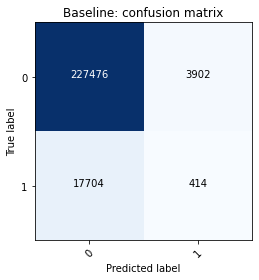

In [38]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");